# Protein New Product: Where is the best location in Mexico City?

## 1. Introduction

#### The importance of creating innovative & sustainable products and introducing them to the market is growing in Mexico City and falling in the hands of small group of private entrepreneurs. Many industries like retail, health & organic foods have been rush by this kind of products but one of this markets lack this kind of products: the fitness industry. 

#### "Okuilli" is a new innovative product that substitutes your regular protein shake by a sustainable made ,organic, high-protein that is made from "tenebrom molitor" a type of insect. This protein is 100% natural.

#### This product is made outside of Mexico City but the entrepreneur wants to introduce into the city´s market. So, some of the questions to be solved will be:

#### 1. Where in the city is best to introduce the product?
#### 2. What neighborhoods are most likely to buy the product?
#### 3. Which places that sell this type of products should he call to sell his products?


## 2. The Data

#### The data that will be used to solve this problem will be of two sources. First, for the list of boroughs which in spanish they are called "Alcaldías" and neighborhoods which are called "Colonias" were found in the government´s open data & to fulfill our objectives for positioning the product we will use the Foursquare Location Data.

In [1]:
#Import all the packages will be using
import pandas as pd
import numpy as np 
import json
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Lib

In [27]:
colonias = pd.read_csv("colonias.csv")
colonias.head()

ALCALDIA                                  COLONIA   Longitud  \
0  MIGUEL HIDALGO                     LOMAS DE CHAPULTEPEC  19.422841   
1  MIGUEL HIDALGO  LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC)  19.410616   
2  MIGUEL HIDALGO                     DEL BOSQUE (POLANCO)  19.434219   
3        COYOACAN               PEDREGAL DE SANTA URSULA I  19.314862   
4        COYOACAN                                 AJUSCO I  19.324571   

     Latitud  
0 -99.215794  
1 -99.226249  
2 -99.209404  
3 -99.147795  
4 -99.156160

In [29]:
colonias.rename(columns={"Longitud":"latitude","Latitud":"longitude"},inplace= True)
colonias.head()

ALCALDIA                                  COLONIA   latitude  \
0  MIGUEL HIDALGO                     LOMAS DE CHAPULTEPEC  19.422841   
1  MIGUEL HIDALGO  LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC)  19.410616   
2  MIGUEL HIDALGO                     DEL BOSQUE (POLANCO)  19.434219   
3        COYOACAN               PEDREGAL DE SANTA URSULA I  19.314862   
4        COYOACAN                                 AJUSCO I  19.324571   

   longitude  
0 -99.215794  
1 -99.226249  
2 -99.209404  
3 -99.147795  
4 -99.156160

In [30]:
colonias.dropna(inplace=True)
colonias.shape

(1807, 4)

In [31]:
print('The dataframe has {} boroughs ("ALCALDIAS") and {} neighborhoods("COLONIAS").'.format(
        len(colonias['ALCALDIA'].unique()),
        colonias.shape[0]
    )
)

The dataframe has 16 boroughs ("ALCALDIAS") and 1807 neighborhoods("COLONIAS").


In [32]:
#Mexico City Coordinates 
address = 'Mexico City, Mexico'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of  are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of  are 19.4326296, -99.1331785.


In [19]:
# Map of Mexico City using latitude and longitude values
map_CDMX = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
for lat, lng, borough, neighborhood in zip(colonias['latitude'], colonias['longitude'], colonias['ALCALDIA'], colonias['COLONIA']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_CDMX)  
    
map_CDMX

In [34]:
#Function
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)   
        

In [35]:
#Lets get the Venues for the Foursquare API
CDMX_venues = getNearbyVenues(names=colonias['COLONIA'],
                                   latitudes=colonias['latitude'],
                                   longitudes=colonias['longitude']
                                  )


LOMAS DE CHAPULTEPEC
LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC)
DEL BOSQUE (POLANCO)
PEDREGAL DE SANTA URSULA I
AJUSCO I
VISTAS DEL MAUREL (U HAB)
IGNACIO ZARAGOZA I
CENTRO II
VALENTIN GOMEZ FARIAS
MORELOS II
NICOLAS BRAVO
5 DE MAYO
PLUTARCO ELIAS CALLES
CAMPESTRE COYOACAN (FRACC)
JANITZIO
FELIPE ANGELES
AZTECA
ARTES GRAFICAS
CUATRO ARBOLES
CTM X CULHUACAN (U HAB)
EMILIANO ZAPATA
SAN FRANCISCO CULHUACAN (PBLO)
PARQUE SAN ANDRES
OLIMPICA
CTM EL RISCO (U HAB)
EL ARBOLILLO 2 (U HAB)
C T M ARAGON (U)
EDUARDO MOLINA II (U HAB)
VILLA DE ARAGON (FRACC)
NUEVA VALLEJO
SAN JUAN DE ARAGON 6A SECCION (U HAB) I
SANTIAGO ATEPETLAC (LA SELVITA) (U HAB)
EL CARMEN
HEROE DE NACOZARI
MAXIMINO AVILA CAMACHO
JOSE MARIA MORELOS Y PAVON I (U HAB)
SAN FELIPE DE JESUS IV
MARTIN CARRERA I
MESA LOS HORNOS, TEXCALTENCO
MIRADOR 1A SECC
LA PRIMAVERA
LOMAS ALTAS DE PADIERNA SUR
LOMAS DE PADIERNA (AMPL)
SAN PEDRO MARTIR (PBLO)
TLALCOLIGIA
SAUZALES CEBADALES (U HAB)
LA NORIA TEPEPAN
POTRERO DE SAN BERNARDINO
SAN ANDRES T

In [36]:
print(CDMX_venues.shape)
CDMX_venues.head()

(38804, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  LOMAS DE CHAPULTEPEC              19.422841              -99.215794   
1  LOMAS DE CHAPULTEPEC              19.422841              -99.215794   
2  LOMAS DE CHAPULTEPEC              19.422841              -99.215794   
3  LOMAS DE CHAPULTEPEC              19.422841              -99.215794   
4  LOMAS DE CHAPULTEPEC              19.422841              -99.215794   

                                 Venue  Venue Latitude  Venue Longitude  \
0                       Studio Gourmet       19.420263       -99.215545   
1                           Loma Linda       19.420156       -99.218127   
2  Cabina Radio Disney 99.3 Grupo Acir       19.420787       -99.215974   
3                          City Market       19.418977       -99.214751   
4                   Barranca Barrilaco       19.422404       -99.219354   

  Venue Category  
0      Gastropub  
1     Steakhouse  
2    Music Venue  
3   Gourmet Shop  
4           Park

## 3. Methodology

#### Let´s look at only data with Venue Categories that are related with fitness, health & welness

In [84]:
health = CDMX_venues[(CDMX_venues["Venue Category"] ==   "Athletics & Sports"  ) | (CDMX_venues["Venue Category"] ==   "Boxing Gym"  ) | (CDMX_venues["Venue Category"] ==   "Climbing Gym"  ) | (CDMX_venues["Venue Category"] ==   "College Gym"  ) | (CDMX_venues["Venue Category"] ==   "Gourmet Shop"  )  | (CDMX_venues["Venue Category"] ==   "Gym"  ) | (CDMX_venues["Venue Category"] ==   "Gym / Fitness Center"  ) | (CDMX_venues["Venue Category"] ==   "Gym Pool"  ) | (CDMX_venues["Venue Category"] ==   "Gymnastics Gym"  ) | (CDMX_venues["Venue Category"] ==   "Health & Beauty Service"  ) | (CDMX_venues["Venue Category"] ==   "Health Food Store"  ) | (CDMX_venues["Venue Category"] ==   "Juice Bar"  ) | (CDMX_venues["Venue Category"] ==   "Molecular Gastronomy Restaurant"  ) | (CDMX_venues["Venue Category"] ==   "National Park"  ) | (CDMX_venues["Venue Category"] ==   "Organic Grocery"  ) | (CDMX_venues["Venue Category"] ==   "Park"  ) | (CDMX_venues["Venue Category"] ==   "Supplement Shop"  ) | (CDMX_venues["Venue Category"] ==   "Vegetarian / Vegan Restaurant"  ) | (CDMX_venues["Venue Category"] ==   "Yoga Studio"  ) ]

In [85]:
health.reset_index(drop = True)

Neighborhood  Neighborhood Latitude  \
0                        LOMAS DE CHAPULTEPEC              19.422841   
1                        LOMAS DE CHAPULTEPEC              19.422841   
2                        LOMAS DE CHAPULTEPEC              19.422841   
3     LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC)              19.410616   
4                        DEL BOSQUE (POLANCO)              19.434219   
...                                       ...                    ...   
3046     EX EJIDO SAN FRANCISCO CULHUACAN III              19.330742   
3047     EX EJIDO SAN FRANCISCO CULHUACAN III              19.330742   
3048                        JARDIN BALBUENA I              19.421584   
3049                        JARDIN BALBUENA I              19.421584   
3050                        JARDIN BALBUENA I              19.421584   

      Neighborhood Longitude                        Venue  Venue Latitude  \
0                 -99.215794                  City Market       19.418977   
1                 -99.215794           Barranca Barrilaco       19.422404   
2                 -99.215794  Green Republic - Matcha Bar       19.419362   
3                 -99.226249        Weight Watchers Lomas       19.409935   
4                 -99.209404                     Commando       19.436115   
...                      ...                          ...             ...   
3046              -99.122131               Sports Fit Gym       19.329140   
3047              -99.122131             Presidente's Gym       19.327288   
3048              -99.105354          Pole Fitness Studio       19.422479   
3049              -99.105354                bulldog's gym       19.418925   
3050              -99.105354                Absolute Yoga       19.422531   

      Venue Longitude                 Venue Category  
0          -99.214751                   Gourmet Shop  
1          -99.219354                           Park  
2          -99.214451  Vegetarian / Vegan Restaurant  
3          -99.221907           Gym / Fitness Center  
4          -99.205144           Gym / Fitness Center  
...               ...                            ...  
3046       -99.125568           Gym / Fitness Center  
3047       -99.124527                            Gym  
3048       -99.108254           Gym / Fitness Center  
3049       -99.106977                            Gym  
3050       -99.109305                    Yoga Studio  

[3051 rows x 7 columns]

In [86]:
health.shape

(3051, 7)

In [102]:
# Let´s count the Health-Fitness-Welness Venues an sort them in descending order:

health2 = health.groupby('Neighborhood').count().sort_values(by = ["Venue Category"], ascending=False)
health2.to_csv("Count_Health.csv")

In [ ]:
# Let´s now use one hot encoding to find the frequency of each category.

In [92]:
# one hot encoding
mx_onehot = pd.get_dummies(health[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
mx_onehot['Neighborhood'] = health['Neighborhood']

mx_onehot.head()

Athletics & Sports  Boxing Gym  Climbing Gym  College Gym  Gourmet Shop  \
3                    0           0             0            0             1   
4                    0           0             0            0             0   
8                    0           0             0            0             0   
23                   0           0             0            0             0   
39                   0           0             0            0             0   

    Gym  Gym / Fitness Center  Gym Pool  Gymnastics Gym  \
3     0                     0         0               0   
4     0                     0         0               0   
8     0                     0         0               0   
23    0                     1         0               0   
39    0                     1         0               0   

    Health & Beauty Service  Health Food Store  Juice Bar  \
3                         0                  0          0   
4                         0                  0          0   
8                         0                  0          0   
23                        0                  0          0   
39                        0                  0          0   

    Molecular Gastronomy Restaurant  National Park  Organic Grocery  Park  \
3                                 0              0                0     0   
4                                 0              0                0     1   
8                                 0              0                0     0   
23                                0              0                0     0   
39                                0              0                0     0   

    Supplement Shop  Vegetarian / Vegan Restaurant  Yoga Studio  \
3                 0                              0            0   
4                 0                              0            0   
8                 0                              1            0   
23                0                              0            0   
39                0                              0            0   

                               Neighborhood  
3                      LOMAS DE CHAPULTEPEC  
4                      LOMAS DE CHAPULTEPEC  
8                      LOMAS DE CHAPULTEPEC  
23  LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC)  
39                     DEL BOSQUE (POLANCO)

In [93]:
first_col = mx_onehot.pop("Neighborhood")
mx_onehot.insert(0, "Neighborhood", first_col)
mx_onehot.head()

Neighborhood  Athletics & Sports  Boxing Gym  \
3                      LOMAS DE CHAPULTEPEC                   0           0   
4                      LOMAS DE CHAPULTEPEC                   0           0   
8                      LOMAS DE CHAPULTEPEC                   0           0   
23  LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC)                   0           0   
39                     DEL BOSQUE (POLANCO)                   0           0   

    Climbing Gym  College Gym  Gourmet Shop  Gym  Gym / Fitness Center  \
3              0            0             1    0                     0   
4              0            0             0    0                     0   
8              0            0             0    0                     0   
23             0            0             0    0                     1   
39             0            0             0    0                     1   

    Gym Pool  Gymnastics Gym  Health & Beauty Service  Health Food Store  \
3          0               0                        0                  0   
4          0               0                        0                  0   
8          0               0                        0                  0   
23         0               0                        0                  0   
39         0               0                        0                  0   

    Juice Bar  Molecular Gastronomy Restaurant  National Park  \
3           0                                0              0   
4           0                                0              0   
8           0                                0              0   
23          0                                0              0   
39          0                                0              0   

    Organic Grocery  Park  Supplement Shop  Vegetarian / Vegan Restaurant  \
3                 0     0                0                              0   
4                 0     1                0                              0   
8                 0     0                0                              1   
23                0     0                0                              0   
39                0     0                0                              0   

    Yoga Studio  
3             0  
4             0  
8             0  
23            0  
39            0

In [94]:
mx_grouped = mx_onehot.groupby('Neighborhood').mean().reset_index()
mx_grouped

Neighborhood  Athletics & Sports  Boxing Gym  Climbing Gym  \
0              10 DE ABRIL                 0.0         0.0           0.0   
1               10 DE MAYO                 0.0         0.0           0.0   
2          12 DE DICIEMBRE                 0.0         0.0           0.0   
3             15 DE AGOSTO                 0.0         0.0           0.0   
4         16 DE SEPTIEMBRE                 0.0         0.0           0.0   
...                    ...                 ...         ...           ...   
1211         ZENON DELGADO                 0.0         0.0           0.0   
1212            ZENTLAPATL                 0.0         0.0           0.0   
1213        ZONA ESCOLAR I                 0.0         0.0           0.0   
1214       ZONA ESCOLAR II                 0.0         0.0           0.0   
1215  ZONA ESCOLAR ORIENTE                 0.0         0.0           0.0   

      College Gym  Gourmet Shop       Gym  Gym / Fitness Center  Gym Pool  \
0             0.0           0.0  0.000000              1.000000       0.0   
1             0.0           0.0  0.500000              0.500000       0.0   
2             0.0           0.0  0.500000              0.500000       0.0   
3             0.0           0.0  1.000000              0.000000       0.0   
4             0.0           0.0  0.000000              0.000000       1.0   
...           ...           ...       ...                   ...       ...   
1211          0.0           0.0  1.000000              0.000000       0.0   
1212          0.0           0.0  1.000000              0.000000       0.0   
1213          0.0           0.0  0.333333              0.333333       0.0   
1214          0.0           0.0  0.000000              0.500000       0.0   
1215          0.0           0.0  0.000000              0.000000       0.0   

      Gymnastics Gym  Health & Beauty Service  Health Food Store  Juice Bar  \
0                0.0                      0.0                0.0   0.000000   
1                0.0                      0.0                0.0   0.000000   
2                0.0                      0.0                0.0   0.000000   
3                0.0                      0.0                0.0   0.000000   
4                0.0                      0.0                0.0   0.000000   
...              ...                      ...                ...        ...   
1211             0.0                      0.0                0.0   0.000000   
1212             0.0                      0.0                0.0   0.000000   
1213             0.0                      0.0                0.0   0.333333   
1214             0.0                      0.0                0.0   0.500000   
1215             0.0                      0.0                0.0   1.000000   

      Molecular Gastronomy Restaurant  National Park  Organic Grocery  Park  \
0                                 0.0            0.0              0.0   0.0   
1                                 0.0            0.0              0.0   0.0   
2                                 0.0            0.0              0.0   0.0   
3                                 0.0            0.0              0.0   0.0   
4                                 0.0            0.0              0.0   0.0   
...                               ...            ...              ...   ...   
1211                              0.0            0.0              0.0   0.0   
1212                              0.0            0.0              0.0   0.0   
1213                              0.0            0.0              0.0   0.0   
1214                              0.0            0.0              0.0   0.0   
1215                              0.0            0.0              0.0   0.0   

      Supplement Shop  Vegetarian / Vegan Restaurant  Yoga Studio  
0                 0.0                            0.0          0.0  
1                 0.0                            0.0          0.0  
2                 0.0                            0.0          0.0  
3     

In [95]:
#Top 5 Venues per Neighborhood

num_top_venues = 5

for hood in mx_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = mx_grouped[mx_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----10 DE ABRIL----
                           venue  freq
0           Gym / Fitness Center   1.0
1             Athletics & Sports   0.0
2              Health Food Store   0.0
3  Vegetarian / Vegan Restaurant   0.0
4                Supplement Shop   0.0


----10 DE MAYO----
                           venue  freq
0                            Gym   0.5
1           Gym / Fitness Center   0.5
2             Athletics & Sports   0.0
3                      Juice Bar   0.0
4  Vegetarian / Vegan Restaurant   0.0


----12 DE DICIEMBRE----
                           venue  freq
0                            Gym   0.5
1           Gym / Fitness Center   0.5
2             Athletics & Sports   0.0
3                      Juice Bar   0.0
4  Vegetarian / Vegan Restaurant   0.0


----15 DE AGOSTO----
                           venue  freq
0                            Gym   1.0
1             Athletics & Sports   0.0
2              Health Food Store   0.0
3  Vegetarian / Vegan Restaurant   0.0
4            

In [ ]:
#Let´s Now Look at the Venues with highest count & see the most common

In [118]:
#Most Common
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [119]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mx_grouped['Neighborhood']

for ind in np.arange(mx_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mx_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       10 DE ABRIL  Gym / Fitness Center           Yoga Studio   
1        10 DE MAYO                   Gym  Gym / Fitness Center   
2   12 DE DICIEMBRE                   Gym  Gym / Fitness Center   
3      15 DE AGOSTO                   Gym           Yoga Studio   
4  16 DE SEPTIEMBRE              Gym Pool           Yoga Studio   

  3rd Most Common Venue  
0        Gymnastics Gym  
1           Yoga Studio  
2           Yoga Studio  
3        Gymnastics Gym  
4        Gymnastics Gym

In [100]:
neighborhoods_venues_sorted.to_csv("Neigh_Sorted.csv")

## 4.Result Section

#### Let´s Cluster to find similar neighborhoods

In [120]:
# set number of clusters
kclusters = 8

grouped_clustering = mx_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 4, 4, 2, 1, 3, 3, 2, 0, 2], dtype=int32)

In [121]:
#Adding clusters

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mx_merged = health

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
mx_merged = mx_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

mx_merged.head() # check the last columns!

Neighborhood  Neighborhood Latitude  \
3                      LOMAS DE CHAPULTEPEC              19.422841   
4                      LOMAS DE CHAPULTEPEC              19.422841   
8                      LOMAS DE CHAPULTEPEC              19.422841   
23  LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC)              19.410616   
39                     DEL BOSQUE (POLANCO)              19.434219   

    Neighborhood Longitude                        Venue  Venue Latitude  \
3               -99.215794                  City Market       19.418977   
4               -99.215794           Barranca Barrilaco       19.422404   
8               -99.215794  Green Republic - Matcha Bar       19.419362   
23              -99.226249        Weight Watchers Lomas       19.409935   
39              -99.209404                     Commando       19.436115   

    Venue Longitude                 Venue Category  Cluster Labels  \
3        -99.214751                   Gourmet Shop               3   
4        -99.219354                           Park               3   
8        -99.214451  Vegetarian / Vegan Restaurant               3   
23       -99.221907           Gym / Fitness Center               5   
39       -99.205144           Gym / Fitness Center               5   

   1st Most Common Venue 2nd Most Common Venue          3rd Most Common Venue  
3                   Park          Gourmet Shop  Vegetarian / Vegan Restaurant  
4                   Park          Gourmet Shop  Vegetarian / Vegan Restaurant  
8                   Park          Gourmet Shop  Vegetarian / Vegan Restaurant  
23  Gym / Fitness Center           Yoga Studio                 Gymnastics Gym  
39  Gym / Fitness Center           Yoga Studio                 Gymnastics Gym

In [122]:
#Mapping Clusters

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mx_merged['Venue Latitude'], mx_merged['Venue Longitude'], mx_merged['Neighborhood'], mx_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [124]:
mx_merged.loc[mx_merged['Cluster Labels'] == 0, mx_merged.columns[[1] + list(range(5, mx_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude           Venue Category  \
77                 19.314862       -99.150517  Health & Beauty Service   
980                19.267178       -99.207449                      Gym   
985                19.267178       -99.207437  Health & Beauty Service   
1670               19.278847       -99.029220  Health & Beauty Service   
3467               19.551950       -99.132835  Health & Beauty Service   
...                      ...              ...                      ...   
35279              19.381998       -99.152443           Gymnastics Gym   
35293              19.381998       -99.152305  Health & Beauty Service   
35449              19.548312       -99.132835  Health & Beauty Service   
37797              19.338305       -99.104440     Gym / Fitness Center   
37802              19.338305       -99.111654  Health & Beauty Service   

       Cluster Labels    1st Most Common Venue 2nd Most Common Venue  \
77                  0  Health & Beauty Service        Gymnastics Gym   
980                 0  Health & Beauty Service                   Gym   
985                 0  Health & Beauty Service                   Gym   
1670                0  Health & Beauty Service        Gymnastics Gym   
3467                0  Health & Beauty Service        Gymnastics Gym   
...               ...                      ...                   ...   
35279               0  Health & Beauty Service        Gymnastics Gym   
35293               0  Health & Beauty Service        Gymnastics Gym   
35449               0  Health & Beauty Service        Gymnastics Gym   
37797               0  Health & Beauty Service  Gym / Fitness Center   
37802               0  Health & Beauty Service  Gym / Fitness Center   

      3rd Most Common Venue  
77               Boxing Gym  
980          Gymnastics Gym  
985          Gymnastics Gym  
1670             Boxing Gym  
3467             Boxing Gym  
...                     ...  
35279            Boxing Gym  
35293            Boxing Gym  
35449            Boxing Gym  
37797        Gymnastics Gym  
37802        Gymnastics Gym  

[80 rows x 7 columns]

### Cluster 2 

In [125]:
mx_merged.loc[mx_merged['Cluster Labels'] == 1, mx_merged.columns[[1] + list(range(5, mx_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude                 Venue Category  \
307                19.448459       -99.201996                      Juice Bar   
940                19.483921       -99.096280                Supplement Shop   
1173               19.248044       -99.174161                            Gym   
1174               19.248044       -99.167220             Athletics & Sports   
1235               19.300551       -99.172828                   Gourmet Shop   
...                      ...              ...                            ...   
38319              19.441216       -99.177536                            Gym   
38322              19.441216       -99.179414           Gym / Fitness Center   
38371              19.441216       -99.180837                            Gym   
38520              19.347360       -99.163929  Vegetarian / Vegan Restaurant   
38542              19.347360       -99.161397  Vegetarian / Vegan Restaurant   

       Cluster Labels          1st Most Common Venue    2nd Most Common Venue  \
307                 1                      Juice Bar              Yoga Studio   
940                 1                Supplement Shop              Yoga Studio   
1173                1             Athletics & Sports                      Gym   
1174                1             Athletics & Sports                      Gym   
1235                1                   Gourmet Shop              Yoga Studio   
...               ...                            ...                      ...   
38319               1                            Gym  Health & Beauty Service   
38322               1                            Gym  Health & Beauty Service   
38371               1                            Gym  Health & Beauty Service   
38520               1  Vegetarian / Vegan Restaurant              Yoga Studio   
38542               1  Vegetarian / Vegan Restaurant              Yoga Studio   

      3rd Most Common Venue  
307          Gymnastics Gym  
940          Gymnastics Gym  
1173         Gymnastics Gym  
1174         Gymnastics Gym  
1235         Gymnastics Gym  
...                     ...  
38319  Gym / Fitness Center  
38322  Gym / Fitness Center  
38371  Gym / Fitness Center  
38520        Gymnastics Gym  
38542        Gymnastics Gym  

[408 rows x 7 columns]

### Cluster 3

In [126]:
mx_merged.loc[mx_merged['Cluster Labels'] == 2, mx_merged.columns[[1] + list(range(5, mx_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude Venue Category  Cluster Labels  \
103                19.324571       -99.158370            Gym               2   
383                19.447507       -99.118246            Gym               2   
787                19.491023       -99.149005            Gym               2   
795                19.491023       -99.149544            Gym               2   
826                19.469390       -99.068226            Gym               2   
...                      ...              ...            ...             ...   
37361              19.299237       -99.077180            Gym               2   
37992              19.392445       -99.242033    Yoga Studio               2   
37999              19.392445       -99.239476            Gym               2   
38002              19.392445       -99.239590            Gym               2   
38232              19.421245       -99.096345            Gym               2   

      1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  
103                     Gym           Yoga Studio        Gymnastics Gym  
383                     Gym           Yoga Studio        Gymnastics Gym  
787                     Gym           Yoga Studio        Gymnastics Gym  
795                     Gym           Yoga Studio        Gymnastics Gym  
826                     Gym           Yoga Studio        Gymnastics Gym  
...                     ...                   ...                   ...  
37361                   Gym           Yoga Studio        Gymnastics Gym  
37992                   Gym           Yoga Studio        Gymnastics Gym  
37999                   Gym           Yoga Studio        Gymnastics Gym  
38002                   Gym           Yoga Studio        Gymnastics Gym  
38232                   Gym           Yoga Studio        Gymnastics Gym  

[343 rows x 7 columns]

### Cluster 4 

In [127]:
mx_merged.loc[mx_merged['Cluster Labels'] == 3, mx_merged.columns[[1] + list(range(5, mx_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude                 Venue Category  \
3                  19.422841       -99.214751                   Gourmet Shop   
4                  19.422841       -99.219354                           Park   
8                  19.422841       -99.214451  Vegetarian / Vegan Restaurant   
149                19.413112       -99.097701                           Park   
161                19.413112       -99.093032                            Gym   
...                      ...              ...                            ...   
38626              19.312615       -99.135053        Health & Beauty Service   
38634              19.323562       -99.101641             Athletics & Sports   
38640              19.323562       -99.106951                           Park   
38643              19.323562       -99.100764                            Gym   
38646              19.323562       -99.101212             Athletics & Sports   

       Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
3                   3                  Park          Gourmet Shop   
4                   3                  Park          Gourmet Shop   
8                   3                  Park          Gourmet Shop   
149                 3                  Park          Gourmet Shop   
161                 3                  Park          Gourmet Shop   
...               ...                   ...                   ...   
38626               3                  Park                   Gym   
38634               3    Athletics & Sports                  Park   
38640               3    Athletics & Sports                  Park   
38643               3    Athletics & Sports                  Park   
38646               3    Athletics & Sports                  Park   

               3rd Most Common Venue  
3      Vegetarian / Vegan Restaurant  
4      Vegetarian / Vegan Restaurant  
8      Vegetarian / Vegan Restaurant  
149                              Gym  
161                              Gym  
...                              ...  
38626           Gym / Fitness Center  
38634                            Gym  
38640                            Gym  
38643                            Gym  
38646                            Gym  

[653 rows x 7 columns]

### Cluster 5 

In [128]:
mx_merged.loc[mx_merged['Cluster Labels'] == 4, mx_merged.columns[[1] + list(range(5, mx_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude        Venue Category  \
120                19.305300       -99.172828          Gourmet Shop   
128                19.305300       -99.173002                  Park   
129                19.305300       -99.170784  Gym / Fitness Center   
136                19.305300       -99.170148                  Park   
141                19.305300       -99.173869  Gym / Fitness Center   
...                      ...              ...                   ...   
38722              19.330742       -99.125568  Gym / Fitness Center   
38740              19.330742       -99.124527                   Gym   
38747              19.421584       -99.108254  Gym / Fitness Center   
38780              19.421584       -99.106977                   Gym   
38801              19.421584       -99.109305           Yoga Studio   

       Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
120                 4                  Park  Gym / Fitness Center   
128                 4                  Park  Gym / Fitness Center   
129                 4                  Park  Gym / Fitness Center   
136                 4                  Park  Gym / Fitness Center   
141                 4                  Park  Gym / Fitness Center   
...               ...                   ...                   ...   
38722               4                   Gym                  Park   
38740               4                   Gym                  Park   
38747               4           Yoga Studio                   Gym   
38780               4           Yoga Studio                   Gym   
38801               4           Yoga Studio                   Gym   

      3rd Most Common Venue  
120            Gourmet Shop  
128            Gourmet Shop  
129            Gourmet Shop  
136            Gourmet Shop  
141            Gourmet Shop  
...                     ...  
38722  Gym / Fitness Center  
38740  Gym / Fitness Center  
38747  Gym / Fitness Center  
38780  Gym / Fitness Center  
38801  Gym / Fitness Center  

[1138 rows x 7 columns]

### Cluster 6 

In [129]:
mx_merged.loc[mx_merged['Cluster Labels'] == 5, mx_merged.columns[[1] + list(range(5, mx_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude        Venue Category  \
23                 19.410616       -99.221907  Gym / Fitness Center   
39                 19.434219       -99.205144  Gym / Fitness Center   
426                19.438423       -99.109950  Gym / Fitness Center   
494                19.307966       -99.112723  Gym / Fitness Center   
516                19.307966       -99.108465  Gym / Fitness Center   
...                      ...              ...                   ...   
37592              19.365459       -99.286280  Gym / Fitness Center   
37607              19.365459       -99.281788  Gym / Fitness Center   
37609              19.365459       -99.281504  Gym / Fitness Center   
37615              19.361565       -99.286280  Gym / Fitness Center   
38164              19.448551       -99.206801  Gym / Fitness Center   

       Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
23                  5  Gym / Fitness Center           Yoga Studio   
39                  5  Gym / Fitness Center           Yoga Studio   
426                 5  Gym / Fitness Center           Yoga Studio   
494                 5  Gym / Fitness Center           Yoga Studio   
516                 5  Gym / Fitness Center           Yoga Studio   
...               ...                   ...                   ...   
37592               5  Gym / Fitness Center           Yoga Studio   
37607               5  Gym / Fitness Center           Yoga Studio   
37609               5  Gym / Fitness Center           Yoga Studio   
37615               5  Gym / Fitness Center           Yoga Studio   
38164               5  Gym / Fitness Center           Yoga Studio   

      3rd Most Common Venue  
23           Gymnastics Gym  
39           Gymnastics Gym  
426          Gymnastics Gym  
494          Gymnastics Gym  
516          Gymnastics Gym  
...                     ...  
37592        Gymnastics Gym  
37607        Gymnastics Gym  
37609        Gymnastics Gym  
37615        Gymnastics Gym  
38164        Gymnastics Gym  

[186 rows x 7 columns]

### Cluster 7 

In [130]:
mx_merged.loc[mx_merged['Cluster Labels'] == 6, mx_merged.columns[[1] + list(range(5, mx_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude        Venue Category  \
566                19.335562       -99.116413    Athletics & Sports   
1527               19.478277       -99.179197    Athletics & Sports   
1536               19.478277       -99.179368    Athletics & Sports   
2282               19.294003       -99.070783    Athletics & Sports   
2759               19.332254       -99.071550    Athletics & Sports   
...                      ...              ...                   ...   
36939              19.474330       -99.178094  Gym / Fitness Center   
36943              19.474330       -99.178399    Athletics & Sports   
36945              19.474330       -99.179197    Athletics & Sports   
36967              19.474330       -99.179368    Athletics & Sports   
38088              19.466850       -99.210747    Athletics & Sports   

       Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
566                 6    Athletics & Sports        Gymnastics Gym   
1527                6    Athletics & Sports        Gymnastics Gym   
1536                6    Athletics & Sports        Gymnastics Gym   
2282                6    Athletics & Sports        Gymnastics Gym   
2759                6    Athletics & Sports        Gymnastics Gym   
...               ...                   ...                   ...   
36939               6    Athletics & Sports  Gym / Fitness Center   
36943               6    Athletics & Sports  Gym / Fitness Center   
36945               6    Athletics & Sports  Gym / Fitness Center   
36967               6    Athletics & Sports  Gym / Fitness Center   
38088               6    Athletics & Sports        Gymnastics Gym   

      3rd Most Common Venue  
566              Boxing Gym  
1527             Boxing Gym  
1536             Boxing Gym  
2282             Boxing Gym  
2759             Boxing Gym  
...                     ...  
36939        Gymnastics Gym  
36943        Gymnastics Gym  
36945        Gymnastics Gym  
36967        Gymnastics Gym  
38088            Boxing Gym  

[79 rows x 7 columns]

### Cluster 8 

In [131]:
mx_merged.loc[mx_merged['Cluster Labels'] == 6, mx_merged.columns[[1] + list(range(5, mx_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude        Venue Category  \
566                19.335562       -99.116413    Athletics & Sports   
1527               19.478277       -99.179197    Athletics & Sports   
1536               19.478277       -99.179368    Athletics & Sports   
2282               19.294003       -99.070783    Athletics & Sports   
2759               19.332254       -99.071550    Athletics & Sports   
...                      ...              ...                   ...   
36939              19.474330       -99.178094  Gym / Fitness Center   
36943              19.474330       -99.178399    Athletics & Sports   
36945              19.474330       -99.179197    Athletics & Sports   
36967              19.474330       -99.179368    Athletics & Sports   
38088              19.466850       -99.210747    Athletics & Sports   

       Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
566                 6    Athletics & Sports        Gymnastics Gym   
1527                6    Athletics & Sports        Gymnastics Gym   
1536                6    Athletics & Sports        Gymnastics Gym   
2282                6    Athletics & Sports        Gymnastics Gym   
2759                6    Athletics & Sports        Gymnastics Gym   
...               ...                   ...                   ...   
36939               6    Athletics & Sports  Gym / Fitness Center   
36943               6    Athletics & Sports  Gym / Fitness Center   
36945               6    Athletics & Sports  Gym / Fitness Center   
36967               6    Athletics & Sports  Gym / Fitness Center   
38088               6    Athletics & Sports        Gymnastics Gym   

      3rd Most Common Venue  
566              Boxing Gym  
1527             Boxing Gym  
1536             Boxing Gym  
2282             Boxing Gym  
2759             Boxing Gym  
...                     ...  
36939        Gymnastics Gym  
36943        Gymnastics Gym  
36945        Gymnastics Gym  
36967        Gymnastics Gym  
38088            Boxing Gym  

[79 rows x 7 columns]

## The results for clustering are the following: 

#### Cluster 1 has only 3 wellness type of shops were Health & Beauty Venues are the most common type.
#### Cluster 2 has 4 wellness type of shops were there is a variety of common venues.
#### Cluster 3 has 10 wellness type of shops were the most common Venues are Gyms.
#### Cluster 4 has 12 wellness type of shops were there is a variety of common venues
#### Cluster 4 has non welness type of shops were there is a variety of common venues
#### Cluster 6 has non wellness type of shops but the most common venues are Gym/Fitness venues that are considered boutique type of gyms.
#### Cluster 7 characterizes of having non welness shops and only Athletuc & Sport venues.
#### Cluster 8 has de charateristic of having all the parks.


In [123]:
mx_merged.to_csv("Clustering_Results.csv")

## 5. Discussion Section


### - The boroughs of Coyoacan, Iztapalapa, Alvaro Obregon, Gustavo Madero, Benito Juarez, Tlalpan & Miguel Hidalgo make more than 60% of the Venues.

### - Top Neighborhoods: 

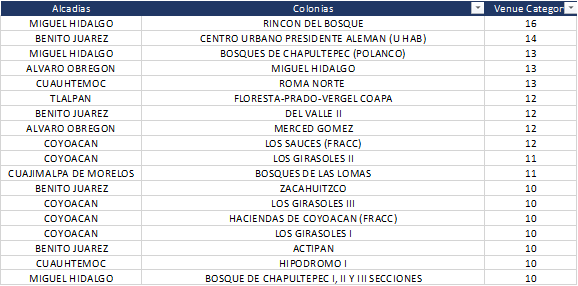

## - Results: 
## Best cluster to call & sell product: Cluster 4 & 5
## Best cluster that have opportunity to open a store: Cluster 3 & 6


# Recommendations

## Choose to sell in stores in the top neighborhoods of the Alcadías of Cluster number 5, were wellness shops represent only 0.87% of the venues. This is an opportunity because there is probably more market share in a place were there is a lot of venues and not so many products offered. 


## Choose to open store in Alvaro Obregon or Iztapalapa, were the boutique gyms are the trend. 


## 6. Conclusions